## Проект "Определение перспективного тарифа для телеком компании"

Исходные данные:  для компании «Мегалайн» — федерального оператора сотовой связи, клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Коммерческий департамент хочет скорректировать рекламный бюджет. 

**Задача** - определить какой тариф приносит больше денег на основании выборки 500 пользователей «Мегалайна»

### Описание тарифов:  

**Тариф «Смарт»**  
Ежемесячная плата: 550 рублей  
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика  
Стоимость услуг сверх тарифного пакета:  
минута разговора: 3 рубля  
сообщение: 3 рубля  
1 Гб интернет-трафика: 200 рублей  

**Тариф «Ультра»**  
Ежемесячная плата: 1950 рублей  
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика  
Стоимость услуг сверх тарифного пакета:  
минута разговора: 1 рубль  
сообщение: 1 рубль  
1 Гб интернет-трафика: 150 рублей  

**Обратите внимание:** «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

### Описание данных

**Таблица users (информация о пользователях):**  
user_id — уникальный идентификатор пользователя  
first_name — имя пользователя  
last_name — фамилия пользователя  
age — возраст пользователя (годы)  
reg_date — дата подключения тарифа (день, месяц, год)  
churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)  
city — город проживания пользователя  
tariff — название тарифного плана  

**Таблица calls (информация о звонках):**  
id — уникальный номер звонка  
call_date — дата звонка  
duration — длительность звонка в минутах  
user_id — идентификатор пользователя, сделавшего звонок  

**Таблица messages (информация о сообщениях):**
id — уникальный номер сообщения  
message_date — дата сообщения  
user_id — идентификатор пользователя, отправившего сообщение  

**Таблица internet (информация об интернет-сессиях):**    
id — уникальный номер сессии  
mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)  
session_date — дата интернет-сессии  
user_id — идентификатор пользователя  

**Таблица tariffs (информация о тарифах):**  
tariff_name — название тарифа  
rub_monthly_fee — ежемесячная абонентская плата в рублях  
minutes_included — количество минут разговора в месяц, включённых в абонентскую плату  
messages_included — количество сообщений в месяц, включённых в абонентскую плату  
mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)  
rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)  
rub_per_message — стоимость отправки сообщения сверх тарифного пакета  
rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)  

### Импорт библиотек 

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
#выгружаем библиотеку для построения графиков
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats as st

#отключение предупреждений (мешали при построении графиков)
import warnings
warnings.filterwarnings('ignore')

### Общая информация

Проведем ознакомление с данными, получим сводную информацию, и полноту данных, проанализируем пустые значения

####  Информация о звонках

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
calls.info()

In [3]:
calls.head()

In [4]:
#изменим тип для столбца 'дата звонка',преобразим в дату, выделим в отдельную клонку месяц
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls['call_date'] = calls['call_date'].dt.round('1D')
calls['month'] = calls['call_date'].dt.month

In [5]:
print('Даты звонков:',calls['call_date'].min(),' - ', calls['call_date'].max())
print('Количество уникальных пользователей:',calls['user_id'].nunique())
print('Доля "нулевых" звонков, %:',calls.loc[calls['duration'] == 0, 'duration'].count()/len(calls)*100)

Так как «Мегалайн» всегда округляет вверх значения минут, округлим значения до целого, изменим тип

In [6]:
calls['duration']= calls['duration'].apply(np.ceil).astype(int) 

Количество звонков, и изменение типа:
<a id="first"></a>

In [7]:
calls.loc[calls['duration'] == 0, 'quantity_calls'] = 0 
calls.loc[calls['duration'] > 0, 'quantity_calls'] = 1
calls['quantity_calls'] = calls['quantity_calls'].astype(int)
calls

In [8]:
calls.info()

####  Информация о сообщениях

In [9]:
messages = pd.read_csv('/datasets/messages.csv')
messages.info()

In [10]:
messages.head()

In [11]:
#изменим тип для столбца 'дата сообщения',преобразим в дату, выделим месяц в отдельный столбец
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages['message_date'] = messages['message_date'].dt.round('1D')
messages['month'] = messages['message_date'].dt.month

In [12]:
print('Даты сообщений:',messages['message_date'].min(),' - ', messages['message_date'].max())
print('Количество уникальных пользователей:',messages['user_id'].nunique())

In [13]:
#переименуем столбец 'id' в 'sms'
messages.rename(columns = {'id':'sms'}, inplace = True)

In [14]:
messages

In [15]:
messages.info()

####  Информация об интернет-сессиях

In [16]:
internet = pd.read_csv('/datasets/internet.csv')
internet.info()

In [17]:
internet.head(10)

In [18]:
#изменим тип для столбца 'дата интернет-сессии',преобразим в дату
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet['session_date'] = internet['session_date'].dt.round('1D')
internet['month'] = internet['session_date'].dt.month

In [19]:
print('Даты сообщений:',internet['session_date'].min(),' - ', internet['session_date'].max())
print('Количество уникальных пользователей:',internet['user_id'].nunique())

Для столбца 'Unnamed: 0' проверить есть ли отличия от индекса, либо это он и есть

In [20]:
def differences(row):
    index = row.name
    Unnamed = row['Unnamed: 0']
    if index != Unnamed: print('отличие')
internet.apply(differences, axis=1)

Значения в столбцах одинаковые можно удалить

In [21]:
internet = internet.drop(['Unnamed: 0'], axis=1)

Округлим трафик в большую сторону, изменим тип

In [22]:
internet['mb_used']= internet['mb_used'].apply(np.ceil).astype(int) 
internet

####  Информация о пользователях

In [23]:
users = pd.read_csv('/datasets/users.csv')
users.info()

Есть пропуски только в столбце churn_date, значит большая часть тарифов не закрыта.

In [24]:
users.head()

In [25]:
print('Количество уникальных пользователей:',users['user_id'].nunique())
print('Количество уникальных городов:',users['city'].nunique())
print('Уникальные тарифы:',users['tariff'].unique())
print('Возраст',users['age'].min(),'-',users['age'].max())
print('5 городов с бОльшим количеством пользователей:')
users.groupby('city').agg({'user_id':'count'}).sort_values(by='user_id', ascending=False).head(5)

In [26]:
#изменим тип для столбца 'дата интернет-сессии',преобразим в дату
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['reg_date'] = users['reg_date'].dt.round('1D')

In [27]:
#Количество пользователей которые уже закрыли свой тариф:
print('Доля пользователей которые уже закрыли свой тариф:',len(users.loc[users['churn_date'].notnull(), 'churn_date'])/len(users)*100)

#### Информация о тарифах

In [28]:
tariffs = pd.read_csv('/datasets/tariffs.csv')
tariffs.info()

In [29]:
tariffs.head(10)

#### Выводы

Проверка таблиц на наличие дубликатов:

In [30]:
names = [calls,users,messages,internet]
names2 = ['Звонки','Пользователи','Сообщения','Интернет']
for i in range(len(names)):
    sum_duplicated = names[i].duplicated().sum()
    print('В таблице {} есть: {} дубликатов'.format(names2[i],sum_duplicated))

### Объединенние таблиц и расчет выручки

#### Таблица 1. Пользователи & Тарифы

Присоединим к таблице с пользователями - таблицу с тарифами, по названию тарифа.

In [31]:
users_tariffs = users.merge(tariffs, how='left', left_on='tariff', right_on='tariff_name') 
users_tariffs.head(5)

#### Группировка таблиц по user_id и месяцу:  

Другие таблицы сгруппируем по user_id и месяцу:  
- для таблицы звонков - сумма минут звонков
- для таблицы сообщений - количество сообщений
- для таблицы интернет - сумма трафика

In [32]:
calls_grouped = calls.groupby(['user_id', 'month']).agg({'duration':'sum','quantity_calls':'sum'}).reset_index() 
messages_grouped = messages.groupby(['user_id', 'month']).agg({'sms':'count'}).reset_index() 
internet_grouped = internet.groupby(['user_id', 'month']).agg({'mb_used':'sum'}).reset_index() 

In [33]:
calls_grouped.head(5)

In [34]:
messages_grouped.head(5)

In [35]:
internet_grouped.head(5)

#### Таблица 2. Звонки & Cмс & Интернет

Теперь объединим таблицы по пользователям и месяцу:

In [36]:
calls_messages = calls_grouped.merge(messages_grouped, on=['user_id','month'], how='outer') 
calls_messages.head(5)
calls_messages.info()

In [37]:
calls_messages_internet = calls_messages.merge(internet_grouped, on=['user_id','month'], how='outer') 
calls_messages_internet

#### Таблица 1 & Таблица 2

In [38]:
df = calls_messages_internet.merge(users_tariffs, how='left', on='user_id') 
df

In [39]:
df.isna().sum()

Заполним пустые значения нулями:

In [40]:
df.loc[df['duration'].isna(), 'duration']  = 0
df.loc[df['sms'].isna(), 'sms']  = 0
df.loc[df['mb_used'].isna(), 'mb_used']  = 0
df.loc[df['quantity_calls'].isna(), 'quantity_calls']  = 0
df.loc[df['churn_date'].isna(),'churn_date'] = 0

In [41]:
df.info()

In [42]:
#изменим тип столбцов на целочисленный
col = (
        ['duration','quantity_calls','sms','mb_used','age','quantity_calls','messages_included',
         'mb_per_month_included','minutes_included','rub_monthly_fee',
          'rub_per_gb', 'rub_per_message','rub_per_minute']
)
for element in col:
    df[element] = df[element].astype(int)

df.info() 

In [43]:
data = df
data.info() 

In [44]:
#Удалим дублирующий столбец  
data = data.drop(['churn_date','tariff_name'], axis=1)  
data.info()  

#### Расчет помесячной выручки с каждого пользователя 

In [45]:
data.info()

In [46]:
import math
def profit(row):
    
    total = a = b = c= 0
        
    if row['duration'] > row['minutes_included']: 
        a = (row['duration'] - row['minutes_included']) * row['rub_per_minute'] 
    else:
        a = 0
        
    if row['sms'] > row['messages_included']: 
        b = (row['sms'] - row['messages_included']) * row['rub_per_message'] 
    else:
        b = 0
        
    if row['mb_used'] > row['mb_per_month_included']: 
        c = math.ceil( (row['mb_used'] - row['mb_per_month_included']) /1024) * row['rub_per_gb']
    else:
        с = 0
        
    total =row['rub_monthly_fee'] + a + b + c
    
    return total
    
data['profit'] = data.apply(profit, axis=1)

### Анализ тарифов

In [47]:
print('Пользователи, которые Не привысили тариф:')
sfc = data.query('profit == rub_monthly_fee and tariff == "smart"')['profit'].count()
sfp = data.query('profit == rub_monthly_fee and tariff == "smart"')['profit'].sum()
print('Smart:',sfc,'|',sfp)
ufc = data.query('profit == rub_monthly_fee and tariff == "ultra"')['profit'].count()
ufp = data.query('profit == rub_monthly_fee and tariff == "ultra"')['profit'].sum()
print('Ultra:',ufc,'|',ufp)
print('----------------------------------')
print('Пользователи, которые привысили тариф:') 
snc = data.query('profit > rub_monthly_fee and tariff == "smart"')['profit'].count()
sn = data.query('profit > rub_monthly_fee and tariff == "smart"')['profit'].sum()
print('Smart:',snc,'|',sn)
unc = data.query('profit > rub_monthly_fee and tariff == "ultra"')['profit'].count()
un = data.query('profit > rub_monthly_fee and tariff == "ultra"')['profit'].sum() 
print('Ultra:',unc,' |',un)

In [48]:
smart_p = (sfp + sn)/(sfc + snc)
print ('Выручка с пользователя Smart',smart_p)
ultra_p = (ufp + un)/(ufc + unc)
print ('Выручка с пользователя Ultra',ultra_p)

#### Выручка тарифа "Smart"

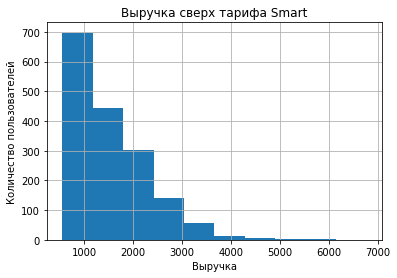

In [49]:
report = data.query('profit > rub_monthly_fee and tariff == "smart"')
report['profit'].hist()
plt.xlabel('Выручка'), plt.ylabel('Количество пользователей')
plt.title('Выручка сверх тарифа Smart')

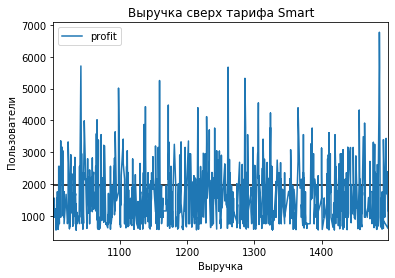

In [50]:

fig, ax = plt.subplots()
ax.hlines(1950, 0, 2000)
report.plot(x='user_id', y='profit',ax=ax)

plt.xlabel('Выручка'), plt.ylabel('Пользователи')
plt.title('Выручка сверх тарифа Smart')

У нас много пользователей тарифа Smart которые платят сверх фиксированной части тарифа. Посмотрим есть ли такие кто постоянно переплачивает? И есть ли возможность предложить тариф Ultra? Посчитаем тех пользователей, кто переплачивал более трех месяцев.

In [51]:
report3 = data.query('profit >= 1950 and tariff == "smart"')
report3.groupby(['user_id'])['month'].count()
print('Можем предложить повышенный тариф', report3.query('month >= 3')['user_id'].count(),'пользователям')

Посмотрим на примере одного пользователя: user_id == "1496". Он стабильно на протяжении 8ми месяцев платит за дополнительный траффик. Возможно предложив таким пользователям передти на тариф Ultra:  
 - в долгосрочной перспективе увеличим выручку  
 - не потеряем клиента, ему могут предложить более выгодные условия другие операторы связи  
 - повысим репутацию компании, которая проявляет заботу о своих клиентах.  

In [52]:
report_user1496 = data.query('user_id == "1496"')
report_user1496

####  Выручка тарифа "Ultra"

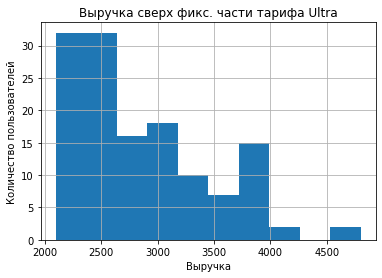

In [53]:
report2 = data.query('profit > rub_monthly_fee and tariff == "ultra"')
report2['profit'].hist()
plt.xlabel('Выручка'), plt.ylabel('Количество пользователей')
plt.title('Выручка сверх фикс. части тарифа Ultra')

#### Вывод №1

P.S. Скажите, такие выводы и предложения уместны? Подскажите, где можно почитать как правильно писать отчеты?

Мы сравнили выручку двух тарифов и выявили, что большое количество пользователей просто выходят за рамки тарифа Smart. Видимо те пользователи которые хотят платить меньше - в резульате платят больше. А может стоит предложить им тариф Ultra? Мы выявили таких пользователей, их оказалось в нашей выборке 448 человек. Но так ли различаются  тарифы, рассмотрим в разделе Гипотезы.

#### Среднее количество, дисперсия и стандартное отклонение 

А теперь рассмотрим минуты звонков, смс и траффик по двум тарифам

In [54]:
data.groupby('tariff')[['duration', 'sms', 'mb_used']].agg({'mean','var','std','median'}).T.style.format('{:.0f}')

In [55]:
import plotly.express as px

# типичные характеристики, пример

columns = ['duration', 'sms', 'mb_used','profit']

for col in columns:
    
    fig = px.histogram(data, x = col, marginal = 'box', color = 'tariff', title = 'Распределение '+col)
    fig.show()
    

#### Минуты разговора по каждому тарифу в месяц

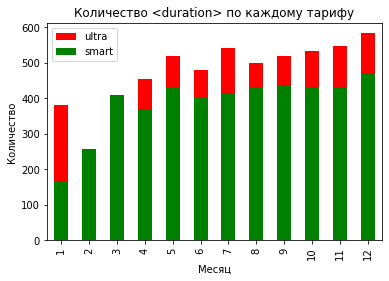

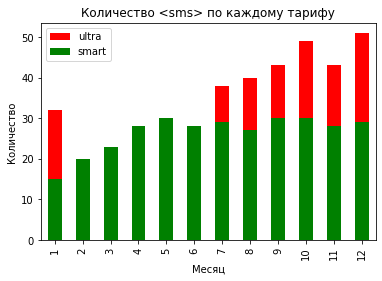

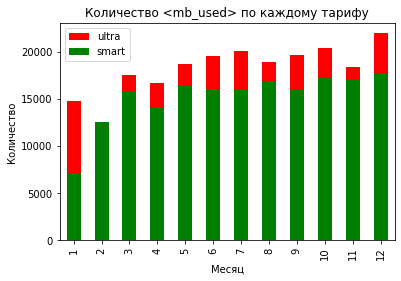

In [56]:
columns = ['duration', 'sms', 'mb_used']

for col in columns:
    ax = data[data['tariff'] == 'ultra'].groupby('month').agg({col:'median'}).plot(kind='bar', y=col, color = 'red', label = 'ultra')
    data[data['tariff'] == 'smart'].groupby('month').agg({col:'median'}).plot(kind='bar', y=col, ax=ax, color = 'green', label = 'smart')
    plt.xlabel('Месяц'), plt.ylabel('Количество')
    plt.title('Количество <{}> по каждому тарифу'.format(col))


### Гипотезы

Будем использовать t-критерий Стьюдента, так как сравниваемые выборки независимы между собой.
Гипотеза о равенстве средних двух генеральных совокупностей.


####  Гипотеза 1
Сформулируем нулевую гипотезу и альтернативную ей:  
H₀: Средняя выручка пользователей тарифов «Ультра» и «Смарт» НЕ различается  
H₁: Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

Построим распределение на предположении, что гипотеза H₀ верна.Если H₀ верна, вероятность попасть ближе к предполагаемому в ней среднему велика, а вот если выборочное среднее далеко от него — такой результат очень маловероятен.

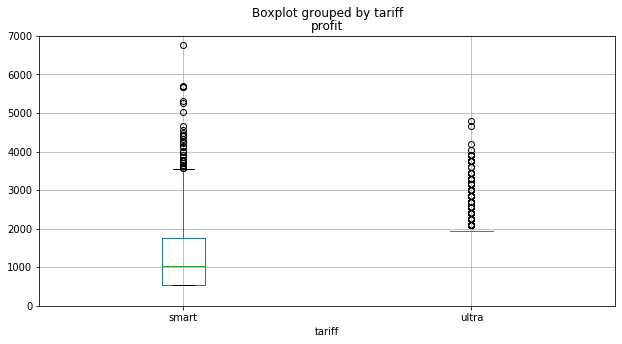

In [57]:
data.boxplot('profit', by='tariff', figsize=(10,5)).set_ylim(0,7000)

In [58]:
#функция убирает выбросы
def abnormal(i):
    min_value = i['profit'].min()
    iqr = i['profit'].quantile(0.75) - i['profit'].quantile(0.25)
    q1 = i['profit'].quantile(0.25) - 1.5 * iqr
    q4 = i['profit'].quantile(0.75) + 1.5 * iqr
    if q1 < min_value :
        q1 = min_value
    i = i.query(' @q1 <= profit <= @q4'.format(element))
    print('Выручка для тарифа - от {:.2f} до {:.2f}'.format(q1, q4))
    return i 

smart = abnormal(data.query('tariff == "smart"'))
ultra = abnormal(data.query('tariff == "ultra"'))

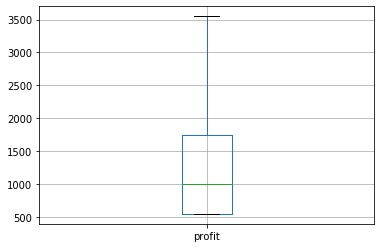

In [59]:
smart.boxplot('profit')

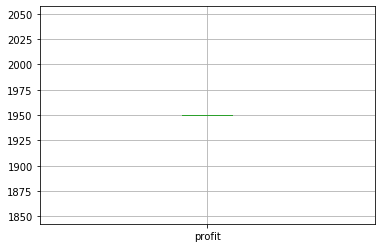

In [60]:
ultra.boxplot('profit')

In [61]:
#критический уровень статистической значимости
alpha = 0.05
#проверяем гипотезу о равенстве средних двух независимых совокупностей
results = st.ttest_ind(smart['profit'],ultra['profit'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

**Вывод №1**

Мы получили очень маленькое значение p-value, отвергаем нулевую гипотезу, различия по средней выручке тарифов есть.

#### Гипотеза 2

Сформулируем гипотезы:  
H₀: Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов  
H₁: Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [62]:
data['region'] = np.where(data['city'] == 'Москва', 'Москва', 'Другие регионы')

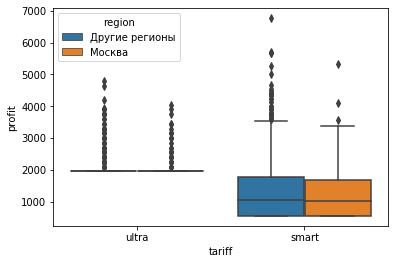

In [63]:
sns.boxplot(x='tariff', y='profit', hue='region', data=data)

In [64]:
#воспользуемся функцией - уберем выбросы
moscow = abnormal(data.query('region == "Москва"'))
other = abnormal(data.query('region == "Другие регионы"'))

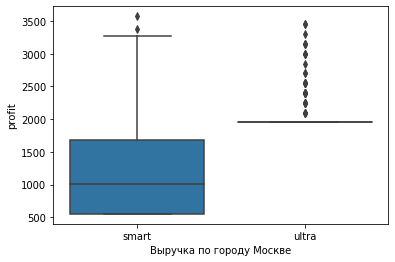

In [65]:
sns.boxplot(x='tariff', y='profit', data=moscow)
plt.xlabel('Выручка по городу Москве'), 

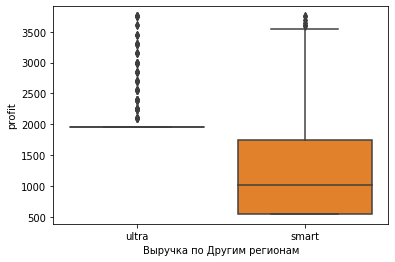

In [66]:
sns.boxplot(x='tariff', y='profit', data=other)
plt.xlabel('Выручка по Другим регионам')

In [67]:
#критический уровень статистической значимости
alpha = 0.05
#проверяем гипотезу о равенстве средних двух независимых совокупностей
results = st.ttest_ind(data.query('region == "Москва"')['profit'], data.query('region == "Другие регионы"')['profit'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

## Общий вывод

Мы провели анализ двух тарифов Ultra и Smart компании «Мегалайна», где в выборке были 500 пользователей из 76 городов, 20% из которых были из Москвы. Входными данными мы получили 5 таблиц, которые в процессе объединили в одну, сгруппировав данные по пользователям и месяцам. Округлили  минуты звонков до целого, в большую сторону. Соответсвенно поступили и с мегабайтами, округлив до Гб. Добавили расчетный столбец с выручкой: 
- По тарифу Smart -  оказалось, что большое количество пользователей перерасходует пакет трафика, тем самым докупая дополнительно гигабайты. Мы выявили большое количество пользователей, которые вполне могли бы пользоваться тарифом Ultra.  
- По тарифу Ultra - совсем немного пользователей выходят за рамки фиксированной части, поэтому дополнительной выручки меньше. Но мы расчитали выручку на каждого пользователя и получилось, что c каждого пользователя Ultra мы получаем больше денег.  
 
Также  стало понятно, что более ценная часть тарифов - это интеренет-трафик. Именно он больше нужен нашим пользователям, и именно с него мы получаем большую часть денег в Smarte. 
Смс - на Ultre пользуются мало, наверно проще позвонить, так как количество минут на этом тарифе не расходуют полностью. В Smarte наоборот пакет минут в среднем расходуется практически полностью, но также может быть и отклонение в 200минут. Смс по этому тарифу тоже расходуются практически полностью. Возможно люди пользуются смс, чтобы съэкономить минуты. Для тарифа Smart - Январь и Февраль самые спокойные месяцы. Для тарифа Ultra сохраняется небольшая тенденция роста звонков/смс/трафика от Января к Декабрю.  

Выдвинув гипотезу, что средняя выручка пользователей тарифов «Ультра» и «Смарт» НЕ различается, и получили опровержение, что вероятность этого очень мала. Поэтому существенное различие между тарифами есть.    
Мы выдвинули гипотезу, что средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов, и получили, что с большей долей вероятности так и есть. Город значения не имеет, видимо поотому что потребности людей в интеренете/звонках/смс по разным городам совпадают.  

Главная задача проекта: определить какой тариф приносит больше денег, хоть это и совершенно  разные тарифы, что  вообщем-то имеет свой плюс для разных пользователей, имеет смысл привлекать больше к тарифу Ultra, именно с нег мы получаем больше выручки. У нас есть большое количество пользователей, которым мы можем предложить этот тариф.  
